#Data Preparation

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
np.random.seed(1337)
import tensorflow as tf
np.random.seed(1337)
from tensorflow import keras
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

batch_size = 32
img_height = 150
img_width = 150

dir = '/content/drive/Shareddrives/wakaranai/acne/acne_img'

datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train_ds = datagen.flow_from_directory(
    dir,
    subset="training",
    seed=0,
    target_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = datagen.flow_from_directory(
    dir,
    subset="validation",
    seed=0,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 278 images belonging to 5 classes.
Found 67 images belonging to 5 classes.


In [ ]:
class_names = list(train_ds.class_indices.keys())
print(class_names)

['Blackhead', 'Nodules', 'Papule', 'Pustules', 'Whitehead', 'acne_model']


In [ ]:
# batchX, batchY = train_ds.next()
# print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

In [ ]:
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
Counter(train_ds.classes)

Counter({0: 41, 1: 48, 2: 40, 3: 104, 4: 45})

In [ ]:
from sklearn.utils import class_weight

weights = compute_class_weight(class_weight = "balanced",
                               classes = np.unique(train_ds.classes),
                               y = train_ds.classes)
weights

array([1.35609756, 1.15833333, 1.39      , 0.53461538, 1.23555556])

In [ ]:
cw = dict(zip(np.unique(train_ds.classes), weights))
cw

{0: 1.3560975609756099,
 1: 1.1583333333333334,
 2: 1.39,
 3: 0.5346153846153846,
 4: 1.2355555555555555}

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    dir,
    validation_split=0.2,
    subset="training",
    seed=0,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = keras.utils.image_dataset_from_directory(
    dir,
    validation_split=0.2,
    subset="validation",
    seed=0,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 345 files belonging to 5 classes.
Using 276 files for training.
Found 345 files belonging to 5 classes.
Using 69 files for validation.


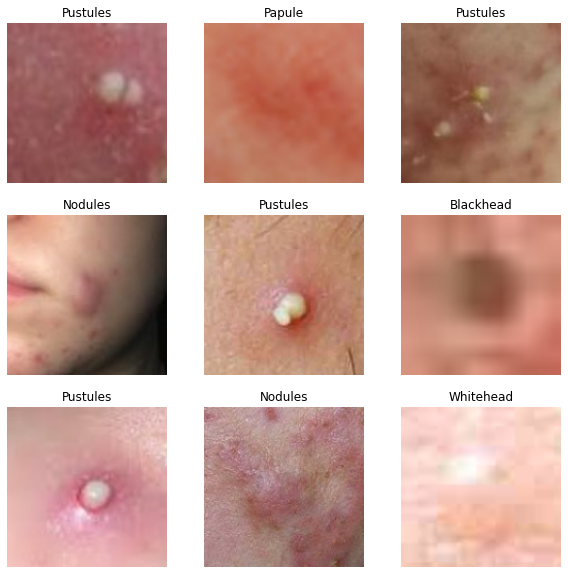

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical",seed=0),
  keras.layers.RandomRotation(0.1,seed=0),
])

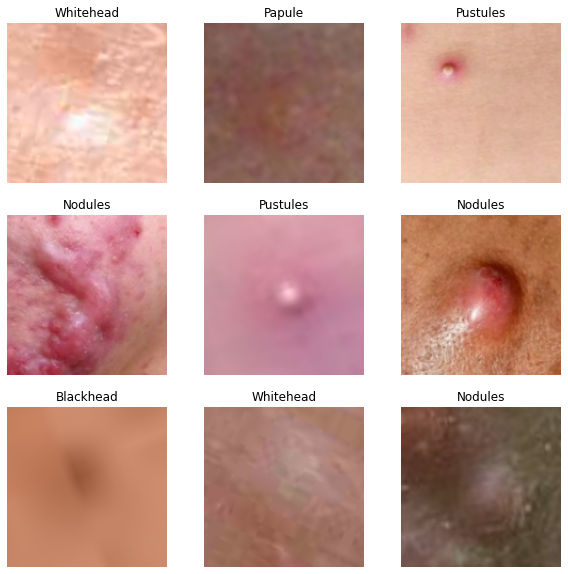

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# Model

In [ ]:
num_classes = 5

model = keras.Sequential([
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
hist = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=cw,
    shuffle=False
)

Epoch 1/100
9/9 [==============================] - 3s 153ms/step - loss: 1.6287 - accuracy: 0.2935 - val_loss: 1.6066 - val_accuracy: 0.3188
Epoch 2/100
9/9 [==============================] - 2s 135ms/step - loss: 1.5785 - accuracy: 0.2210 - val_loss: 1.5664 - val_accuracy: 0.3043
Epoch 3/100
9/9 [==============================] - 2s 137ms/step - loss: 1.5330 - accuracy: 0.2355 - val_loss: 1.4754 - val_accuracy: 0.2899
Epoch 4/100
9/9 [==============================] - 2s 135ms/step - loss: 1.4500 - accuracy: 0.4058 - val_loss: 1.4027 - val_accuracy: 0.3478
Epoch 5/100
9/9 [==============================] - 2s 132ms/step - loss: 1.3989 - accuracy: 0.3370 - val_loss: 1.4482 - val_accuracy: 0.3043
Epoch 6/100
9/9 [==============================] - 2s 135ms/step - loss: 1.4022 - accuracy: 0.3225 - val_loss: 1.3594 - val_accuracy: 0.3043
Epoch 7/100
9/9 [==============================] - 2s 135ms/step - loss: 1.3756 - accuracy: 0.3768 - val_loss: 1.3227 - val_accuracy: 0.4928
Epoch 8/100
9

In [ ]:
#model.save('drive/MyDrive/acne_model')

INFO:tensorflow:Assets written to: drive/MyDrive/acne_model/assets


INFO:tensorflow:Assets written to: drive/MyDrive/acne_model/assets


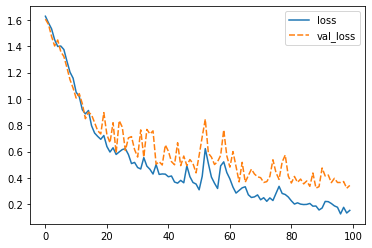

In [ ]:
sns.lineplot(data={idx: hist.history[idx] for idx in ['loss', 'val_loss']})


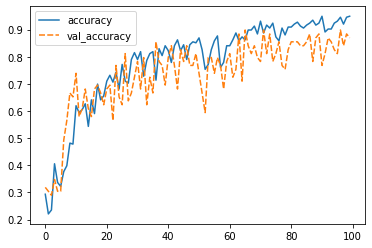

In [ ]:
sns.lineplot(data={idx: hist.history[idx] for idx in ['accuracy', 'val_accuracy']})

## Confusion Matrix

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

predictions = np.array([])
true =  np.array([])

for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(new_model.predict(x), axis=-1)])
  true = np.concatenate([true, y.numpy()])

class_names = ['Blackhead', 'Nodules', 'Papule', 'Pustules', 'Whitehead']
print(classification_report(true, predictions, target_names=class_names,digits =4))

              precision    recall  f1-score   support

   Blackhead     1.0000    1.0000    1.0000         9
     Nodules     0.7778    0.6364    0.7000        11
      Papule     0.8750    0.8750    0.8750         8
    Pustules     0.8214    0.8846    0.8519        26
   Whitehead     0.9333    0.9333    0.9333        15

    accuracy                         0.8696        69
   macro avg     0.8815    0.8659    0.8720        69
weighted avg     0.8683    0.8696    0.8674        69



## afterlife

In [ ]:
predictions

array([1., 3., 3., 1., 3., 1., 4., 3., 0., 3., 4., 4., 2., 3., 2., 3., 4.,
       1., 4., 3., 3., 3., 3., 1., 4., 0., 4., 3., 0., 1., 4., 0., 4., 3.,
       3., 4., 3., 0., 3., 3., 3., 3., 0., 4., 3., 3., 2., 0., 2., 4., 3.,
       0., 4., 3., 4., 3., 3., 2., 3., 1., 2., 3., 3., 1., 2., 1., 0., 4.,
       2.])

In [ ]:
true

array([1., 3., 3., 1., 3., 1., 4., 3., 0., 3., 4., 4., 2., 4., 2., 3., 3.,
       1., 4., 3., 3., 3., 1., 3., 4., 0., 4., 3., 0., 1., 4., 0., 4., 3.,
       3., 4., 1., 0., 3., 3., 3., 3., 0., 4., 3., 3., 2., 0., 2., 4., 1.,
       0., 4., 3., 4., 3., 3., 2., 3., 3., 1., 2., 3., 1., 2., 1., 0., 4.,
       2.])

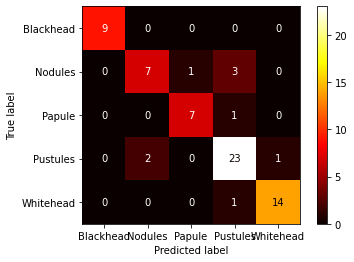

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap='hot')
plt.savefig('confusionmatrix.png')
plt.show()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/Shareddrives/wakaranai/acne/acne_model')

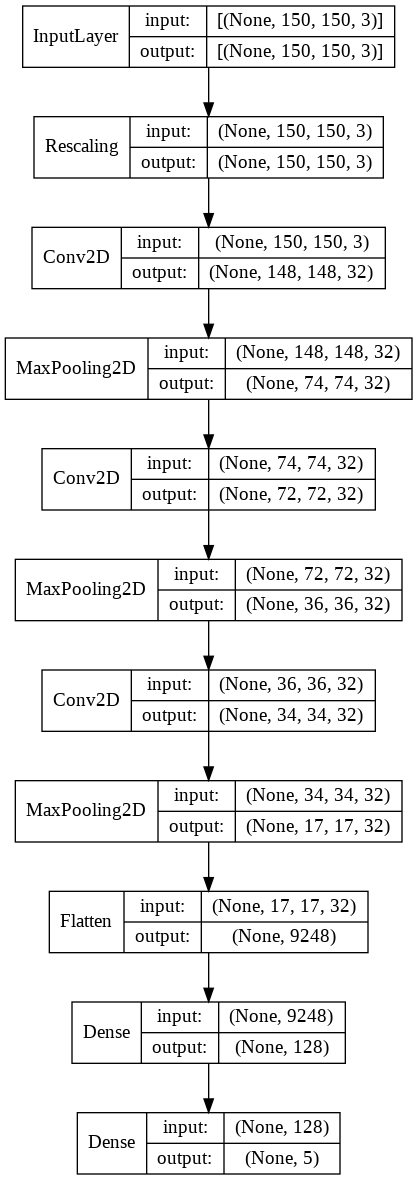

In [ ]:
tf.keras.utils.plot_model(new_model,
                          to_file='embedding.png',
                          show_shapes=True,
                          show_layer_names=False)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(new_model, X_test, y_test)